<a href="https://colab.research.google.com/github/aadityaverma/3DDFA/blob/master/SpecVQGAN_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taming Visually Guided Sound Generation 🖼️ 👉 🔉
This notebook will guide you through the visually-guided sound generation.
We will condition the generation on a set of visual frames extracted from 
an arbitrary video.

[Project Page](https://v-iashin.github.io/SpecVQGAN) 
• [Paper](https://arxiv.org/abs/2110.08791) 
• [Code](https://github.com/v-iashin/SpecVQGAN)

## Installing the Environment

In [ ]:
!pip uninstall torchtext -y # otherwise fails on PytorchLightning import
!pip install pytorch-lightning==1.2.10 omegaconf==2.0.6 albumentations==0.5.2 opencv-python-headless==4.5.4.58

Found existing installation: torchtext 0.11.0
Uninstalling torchtext-0.11.0:
  Successfully uninstalled torchtext-0.11.0
     |████████████████████████████████| 841 kB 4.3 MB/s 
     |████████████████████████████████| 72 kB 619 kB/s 
     |████████████████████████████████| 47.6 MB 140 kB/s 
     |████████████████████████████████| 829 kB 14.0 MB/s 
     |████████████████████████████████| 133 kB 35.4 MB/s 
     |████████████████████████████████| 596 kB 9.2 MB/s 
     |████████████████████████████████| 176 kB 36.1 MB/s 
     |████████████████████████████████| 948 kB 33.5 MB/s 
     |████████████████████████████████| 1.1 MB 35.8 MB/s 
     |████████████████████████████████| 271 kB 50.8 MB/s 
     |████████████████████████████████| 94 kB 194 kB/s 
     |████████████████████████████████| 144 kB 49.9 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=6075dcf0d48b47d06a3fe0641987a0b64b9b295b7233a130c7557ca6ec816b78
  Stored in directory: /root/.cache/p

In [ ]:
# Cloning the repo from GitHub
!git clone https://github.com/v-iashin/SpecVQGAN
%cd SpecVQGAN

Cloning into 'SpecVQGAN'...
remote: Enumerating objects: 396, done.
remote: Counting objects: 100% (396/396), done.
remote: Compressing objects: 100% (323/323), done.
remote: Total 396 (delta 68), reused 372 (delta 45), pack-reused 0
Receiving objects: 100% (396/396), 165.24 MiB | 13.37 MiB/s, done.
Resolving deltas: 100% (68/68), done.
Checking out files: 100% (231/231), done.
/content/SpecVQGAN


## Imports and Device Selection

In [ ]:
import os
import time
from pathlib import Path

import IPython.display as display_audio
import soundfile
import torch
from IPython import display
from matplotlib import pyplot as plt
from torch.utils.data.dataloader import default_collate
from torchvision.utils import make_grid
from tqdm import tqdm

from feature_extraction.demo_utils import (ExtractResNet50, check_video_for_audio,
                                           extract_melspectrogram, load_model,
                                           show_grid, trim_video)
from sample_visualization import (all_attention_to_st, get_class_preditions,
                                  last_attention_to_st, spec_to_audio_to_st,
                                  tensor_to_plt)
from specvqgan.data.vggsound import CropImage

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Select a Model
The model will be automatically downloaded given the `model_name`. 
Use the following reference to select one:

|                               Model Name |                  Info | FID ↓ | Avg. MKL ↓ | Sample Time️ ↓ |
| ---------------------------------------: | --------------------: | ----: | ---------: | ------------: |
| 2021-06-20T16-35-20_vggsound_transformer |              No Feats |  13.5 |        9.7 |           7.7 |
| 2021-07-30T21-03-22_vggsound_transformer |    1 ResNet50 Feature |  11.5 |        7.3 |           7.7 |
| 2021-07-30T21-34-25_vggsound_transformer |   5 ResNet50 Features |  11.3 |        7.0 |           7.9 |
| 2021-07-30T21-34-41_vggsound_transformer | 212 ResNet50 Features |  10.5 |        6.9 |          11.8 |

In [ ]:
model_name = '2021-07-30T21-34-25_vggsound_transformer'
log_dir = './logs'
# loading the models might take a few minutes
config, sampler, melgan, melception = load_model(model_name, log_dir, device)

Using: 2021-07-30T21-34-25_vggsound_transformer (5 ResNet50 Features)


3.68GB [02:53, 21.2MB/s]                            


Unpacking ./logs/2021-07-30T21-34-25_vggsound_transformer.tar.gz to ./logs


281MB [00:15, 18.3MB/s]                           


## Select a Video
We extract visual features and display the corresponding frames.

**Note**: the selected video is trimmed to 10 seconds.
By default, we use the first 10 seconds: adjust `start_sec` if you'd like to 
start from another time.
If the video is shorter than 10 seconds it will be tiled until 10 seconds.

Video Duration: 10.024
Trimmed the input video ./data/vggsound/video/-Qowmc0P9ic_34000_44000.mp4 and saved the output @ ./tmp/-Qowmc0P9ic_34000_44000_trim_to_10s.mp4


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Raw Extracted Representation: (215, 2048)
Post-processed Representation: (5, 2048)
Rendering the Plot with Frames Used in Conditioning


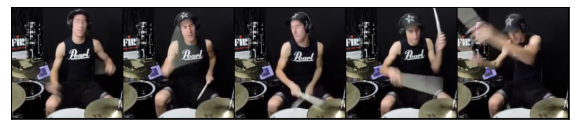

In [ ]:
# Select a video
video_path = './data/vggsound/video/-Qowmc0P9ic_34000_44000.mp4'

# Trim the video
start_sec = 0  # to start with 01:35 use 95 seconds
video_path = trim_video(video_path, start_sec, trim_duration=10)

# Extract Features
extraction_fps = 21.5
feature_extractor = ExtractResNet50(extraction_fps, config.data.params, device)
visual_features, resampled_frames = feature_extractor(video_path)

# Show the selected frames to extract features for
if not config.data.params.replace_feats_with_random:
    fig = show_grid(make_grid(resampled_frames))
    fig.show()

# Prepare Input
batch = default_collate([visual_features])
batch['feature'] = batch['feature'].to(device)
c = sampler.get_input(sampler.cond_stage_key, batch)

## Codebook Reconstruction of the Input Spectrogram

This cell can be ignored if the video doesn't have any audio.

If the video has an audio, it will extract mel-spectrogram from the 
audio track using the same pre-processing pipeline as in our experiments.
This is also useful if you plan to prime the sampling with a half of 
the ground truth codes.

codec_type=video
codec_type=audio

using melspec_10s_22050hz
Original Spectrogram:


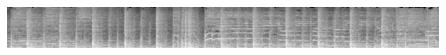

Reconstructed Spectrogram:


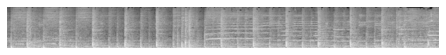

In [ ]:
if check_video_for_audio(video_path):
    # Extract Spectrogram
    audio_fps = 22050
    spectrogram = extract_melspectrogram(video_path, audio_fps)
    spectrogram = {'input': spectrogram}
    # [80, 860] -> [80, 848]
    random_crop = False
    crop_img_fn = CropImage([config.data.params.mel_num, config.data.params.spec_crop_len], random_crop)
    spectrogram = crop_img_fn(spectrogram)

    # Prepare input
    batch = default_collate([spectrogram])
    batch['image'] = batch['input'].to(device)
    x = sampler.get_input(sampler.first_stage_key, batch)

    # Encode and Decode the Spectrogram
    with torch.no_grad():
        quant_z, z_indices = sampler.encode_to_z(x)
        xrec = sampler.first_stage_model.decode(quant_z)

    print('Original Spectrogram:')
    display.display(tensor_to_plt(x, flip_dims=(2,)))
    print('Reconstructed Spectrogram:')
    display.display(tensor_to_plt(xrec, flip_dims=(2,)))
    plt.close()
    plt.close()
else:
    print('Could not find an audio track in the video file...')

## Sample a New Sound Given a Condition

Feel free to adjust the parameters:
- `W_scale (int > 0)`: the output sound duration will be `W_scale * 9.8 seconds`
- `mode (str ['half', 'full'])`: the sampling mode:
    - `full`: the sampling starts with conditioning-only
    - `half`: the sampling will be primed with the first half of the quantized spectrogram representation 
- `temperature (float != 0)`: softmax temperature. $T$ in $\frac{\exp(x_i/T)} {\Sigma_j \exp(x_j/T)}$
- `top_x (int [0, codebook_size])`: the distribution of the next token is cliped to Top-`top_x` codes of the codebook
- `update_every (int >= 0)`: how often to print progress (slows down the sampling speed)
- `full_att_mat (bool)`: 
    - `True`: shows attention at each step at once
    - `False`: shows attention at the current step only

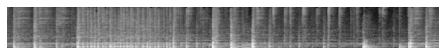

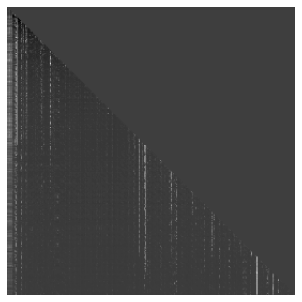

Sampling Time: 46.10 seconds
Sampling Time (with vocoder): 46.21 seconds
Generated: 9.85 seconds
Spectrogram Classifier (K=10):
	playing cymbal: 0.59290
	playing drum kit: 0.22266
	playing bass drum: 0.07923
	playing snare drum: 0.07264
	playing timbales: 0.02011
	playing bongo: 0.00296
	playing congas: 0.00288
	playing guiro: 0.00265
	playing double bass: 0.00094
	playing tambourine: 0.00073

The sample has been saved @ ./logs/-Qowmc0P9ic_34000_44000_trim_to_10s.wav


In [ ]:
# Define Sampling Parameters
W_scale = 1
mode = 'full'
temperature = 1.0
top_x = sampler.first_stage_model.quantize.n_e // 2
update_every = 0  # use > 0 value, e.g. 15, to see the progress of generation (slows down the sampling speed)
full_att_mat = True

# Start sampling
with torch.no_grad():
    start_t = time.time()

    quant_c, c_indices = sampler.encode_to_c(c)
    # crec = sampler.cond_stage_model.decode(quant_c)

    patch_size_i = 5
    patch_size_j = 53

    B, D, hr_h, hr_w = sampling_shape = (1, 256, 5, 53*W_scale)

    z_pred_indices = torch.zeros((B, hr_h*hr_w)).long().to(device)

    if mode == 'full':
        start_step = 0
    else:
        start_step = (patch_size_j // 2) * patch_size_i
        z_pred_indices[:, :start_step] = z_indices[:, :start_step]

    pbar = tqdm(range(start_step, hr_w * hr_h), desc='Sampling Codebook Indices')
    for step in pbar:
        i = step % hr_h
        j = step // hr_h

        i_start = min(max(0, i - (patch_size_i // 2)), hr_h - patch_size_i)
        j_start = min(max(0, j - (patch_size_j // 2)), hr_w - patch_size_j)
        i_end = i_start + patch_size_i
        j_end = j_start + patch_size_j

        local_i = i - i_start
        local_j = j - j_start

        patch_2d_shape = (B, D, patch_size_i, patch_size_j)

        pbar.set_postfix(
            Step=f'({i},{j}) | Local: ({local_i},{local_j}) | Crop: ({i_start}:{i_end},{j_start}:{j_end})'
        )

        patch = z_pred_indices \
            .reshape(B, hr_w, hr_h) \
            .permute(0, 2, 1)[:, i_start:i_end, j_start:j_end].permute(0, 2, 1) \
            .reshape(B, patch_size_i * patch_size_j)

        # assuming we don't crop the conditioning and just use the whole c, if not desired uncomment the above
        cpatch = c_indices
        logits, _, attention = sampler.transformer(patch[:, :-1], cpatch)
        # remove conditioning
        logits = logits[:, -patch_size_j*patch_size_i:, :]

        local_pos_in_flat = local_j * patch_size_i + local_i
        logits = logits[:, local_pos_in_flat, :]

        logits = logits / temperature
        logits = sampler.top_k_logits(logits, top_x)

        # apply softmax to convert to probabilities
        probs = torch.nn.functional.softmax(logits, dim=-1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1)
        z_pred_indices[:, j * hr_h + i] = ix

        if update_every > 0 and step % update_every == 0:
            z_pred_img = sampler.decode_to_img(z_pred_indices, sampling_shape)
            # fliping the spectrogram just for illustration purposes (low freqs to bottom, high - top)
            z_pred_img_st = tensor_to_plt(z_pred_img, flip_dims=(2,))
            display.clear_output(wait=True)
            display.display(z_pred_img_st)

            if full_att_mat:
                att_plot = all_attention_to_st(attention, placeholders=None, scale_by_prior=True)
                display.display(att_plot)
                plt.close()
            else:
                quant_z_shape = sampling_shape
                c_length = cpatch.shape[-1]
                quant_c_shape = quant_c.shape
                c_att_plot, z_att_plot = last_attention_to_st(
                    attention, local_pos_in_flat, c_length, sampler.first_stage_permuter,
                    sampler.cond_stage_permuter, quant_c_shape, patch_2d_shape,
                    placeholders=None, flip_c_dims=None, flip_z_dims=(2,))
                display.display(c_att_plot)
                display.display(z_att_plot)
                plt.close()
                plt.close()
            plt.close()

    # quant_z_shape = sampling_shape
    z_pred_img = sampler.decode_to_img(z_pred_indices, sampling_shape)

    # showing the final image
    z_pred_img_st = tensor_to_plt(z_pred_img, flip_dims=(2,))
    display.clear_output(wait=True)
    display.display(z_pred_img_st)

    if full_att_mat:
        att_plot = all_attention_to_st(attention, placeholders=None, scale_by_prior=True)
        display.display(att_plot)
        plt.close()
    else:
        quant_z_shape = sampling_shape
        c_length = cpatch.shape[-1]
        quant_c_shape = quant_c.shape
        c_att_plot, z_att_plot = last_attention_to_st(
            attention, local_pos_in_flat, c_length, sampler.first_stage_permuter,
            sampler.cond_stage_permuter, quant_c_shape, patch_2d_shape,
            placeholders=None, flip_c_dims=None, flip_z_dims=(2,)
        )
        display.display(c_att_plot)
        display.display(z_att_plot)
        plt.close()
        plt.close()
    plt.close()

    print(f'Sampling Time: {time.time() - start_t:3.2f} seconds')
    waves = spec_to_audio_to_st(z_pred_img, config.data.params.spec_dir_path,
                                config.data.params.sample_rate, show_griffin_lim=False,
                                vocoder=melgan, show_in_st=False)
    print(f'Sampling Time (with vocoder): {time.time() - start_t:3.2f} seconds')
    print(f'Generated: {len(waves["vocoder"]) / config.data.params.sample_rate:.2f} seconds')

    # Melception opinion on the class distribution of the generated sample
    topk_preds = get_class_preditions(z_pred_img, melception)
    print(topk_preds)

save_path = os.path.join(log_dir, Path(video_path).stem + '.wav')
soundfile.write(save_path, waves['vocoder'], config.data.params.sample_rate, 'PCM_24')
print(f'The sample has been saved @ {save_path}')
display_audio.Audio(save_path)

In [ ]:
!echo "Versions of used packages"
!pip freeze

Versions of used packages
absl-py==1.0.0
aiohttp==3.8.1
aiosignal==1.2.0
alabaster==0.7.12
albumentations==0.5.2
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.11.4
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
async-timeout==4.0.2
asynctest==0.13.0
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==4.1.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.10
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2021.10.8
cffi==1.15.0
cftime==1.5.2
chardet==3.0.4
charset-normalizer==2.0.11
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda111==9.4.0
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.26
daft==0.0.4
dask==2.1